# Speed and Memory Usage of Various Linear Regression Solvers

We experiment with several methods for estimating parameter coefficients in linear regression. We compare the methods based on speed and memory useage. Points to remember:

1. There can be significant preprocessing by R and Python prior to calling C functions. Sometimes this preprocessing takes more computation that the underlying algorithm one is trying to use. It may also use a lot of memory. One can often avoid this extra computation by calling more basic R functions (e.g. lm.fit instead of lm).
2. The form of a mathematical expression and the way it is implemented in a computer often should be different. (See  "Computational Statistics" by Gentle who makes this point several times).

For the first point it is worth keeping in mind that "premature optimization is the root of all evil (or at least most of it) in programming." - [Donald Knuth](https://en.wikiquote.org/wiki/Donald_Knuth). The function lm may be significantly slower than lm.fit, but for most applications this will not matter since both will take well under 1 second. However when building complicated models that use linear solvers many times, this can be a significant issue. This point also applies to functions other than lm.


## Speed

In [99]:
library(microbenchmark)
n <- 1000
p <- 10
beta <- 1:p
X <- matrix(rnorm(n*p),nrow=n)
Y <- X%*%beta + rnorm(n)

In [100]:
out <- microbenchmark(lm(Y~X-1),lm.fit(X,Y),.lm.fit(X,Y),solve(t(X)%*%X,t(X)%*%Y),solve(t(X)%*%X)%*%t(X)%*%Y)

In [101]:
summary(out)

expr,min,lq,mean,median,uq,max,neval
lm(Y ~ X - 1),1317.874,1385.7740,1759.5415,1444.7145,1894.6990,5815.184,100
"lm.fit(X, Y)",273.861,287.2885,343.1774,305.0620,357.1210,640.515,100
".lm.fit(X, Y)",230.875,233.9125,254.3718,236.0265,260.1950,350.356,100
"solve(t(X) %*% X, t(X) %*% Y)",122.597,128.6245,151.5123,138.4190,152.3340,301.656,100
solve(t(X) %*% X) %*% t(X) %*% Y,196.749,208.0420,254.5106,216.8160,251.6365,568.180,100


These methods are accessing mostly fortran code. The fortran routines use matrix decompositions such as Cholesky or QR to solve linear systems of equations. How fast do we get to the fortran? Look at the source code and find out.

In [102]:
## what is lm doing
lm
lm.fit
.lm.fit

function (formula, data, subset, weights, na.action, method = "qr", 
    model = TRUE, x = FALSE, y = FALSE, qr = TRUE, singular.ok = TRUE, 
    contrasts = NULL, offset, ...) 
{
    ret.x <- x
    ret.y <- y
    cl <- match.call()
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (method == "model.frame") 
        return(mf)
    else if (method != "qr") 
        warning(gettextf("method = '%s' is not supported. Using 'qr'", 
            method), domain = NA)
    mt <- attr(mf, "terms")
    y <- model.response(mf, "numeric")
    w <- as.vector(model.weights(mf))
    if (!is.null(w) && !is.numeric(w)) 
        stop("'weights' must be a numeric vector")
    offset <- as.vector(model.offset(mf))
    if (!is.null(offset)) {
        if (length(offset) != NROW(y)) 
            stop(gettextf("number of offsets is %d, should equal %d (number of observations)", 
                length(offset), NROW(y)), domain = NA)
    }
    if (is.empty.model(mt)) {
        x <- NULL
        z <- list(coefficients = if (is.matrix(y)) matrix(, 0, 
            3) else numeric(), residuals = y, fitted.values = 0 * 
            y, weights = w, rank = 0L, df.residual = if (!is.null(w)) sum(w != 
            0) else if (is.matrix(y)) nrow(y) else length(y))
        if (!is.null(offset)) {
            z$fitted.values <- offset
            z$residuals <- y - offset
        }
    }
    else {
        x <- model.matrix(mt, mf, contrasts)
        z <- if (is.null(w)) 
            lm.fit(x, y, offset = offset, singular.ok = singular.ok, 
                ...)
        else lm.wfit(x, y, w, offset = offset, singular.ok = singular.ok, 
            ...)
    }
    class(z) <- c(if (is.matrix(y)) "mlm", "lm")
    z$na.action <- attr(mf, "na.action")
    z$offset <- offset
    z$contrasts <- attr(x, "contrasts")
    z$xlevels <- .getXlevels(mt, mf)
    z$call <- cl
    z$terms <- mt
    if (model) 
        z$model <- mf
    if (ret.x) 
        z$x <- x
    if (ret.y) 
        z$y <- y
    if (!qr) 
        z$qr <- NULL
    z
}
<bytecode: 0x5862038>
<environment: namespace:stats>

function (x, y, offset = NULL, method = "qr", tol = 1e-07, singular.ok = TRUE, 
    ...) 
{
    if (is.null(n <- nrow(x))) 
        stop("'x' must be a matrix")
    if (n == 0L) 
        stop("0 (non-NA) cases")
    p <- ncol(x)
    if (p == 0L) {
        return(list(coefficients = numeric(), residuals = y, 
            fitted.values = 0 * y, rank = 0, df.residual = length(y)))
    }
    ny <- NCOL(y)
    if (is.matrix(y) && ny == 1) 
        y <- drop(y)
    if (!is.null(offset)) 
        y <- y - offset
    if (NROW(y) != n) 
        stop("incompatible dimensions")
    if (method != "qr") 
        warning(gettextf("method = '%s' is not supported. Using 'qr'", 
            method), domain = NA)
    chkDots(...)
    z <- .Call(C_Cdqrls, x, y, tol, FALSE)
    if (!singular.ok && z$rank < p) 
        stop("singular fit encountered")
    coef <- z$coefficients
    pivot <- z$pivot
    r1 <- seq_len(z$rank)
    dn <- colnames(x)
    if (is.null(dn)) 
        dn <- paste0("x", 1L:p)
    nmeffects <- c(dn[pivot[r1]], rep.int("", n - z$rank))
    r2 <- if (z$rank < p) 
        (z$rank + 1L):p
    else integer()
    if (is.matrix(y)) {
        coef[r2, ] <- NA
        if (z$pivoted) 
            coef[pivot, ] <- coef
        dimnames(coef) <- list(dn, colnames(y))
        dimnames(z$effects) <- list(nmeffects, colnames(y))
    }
    else {
        coef[r2] <- NA
        if (z$pivoted) 
            coef[pivot] <- coef
        names(coef) <- dn
        names(z$effects) <- nmeffects
    }
    z$coefficients <- coef
    r1 <- y - z$residuals
    if (!is.null(offset)) 
        r1 <- r1 + offset
    if (z$pivoted) 
        colnames(z$qr) <- colnames(x)[z$pivot]
    qr <- z[c("qr", "qraux", "pivot", "tol", "rank")]
    c(z[c("coefficients", "residuals", "effects", "rank")], list(fitted.values = r1, 
        assign = attr(x, "assign"), qr = structure(qr, class = "qr"), 
        df.residual = n - z$rank))
}
<bytecode: 0x5873488>
<environment: namespace:stats>

function (x, y, tol = 1e-07) 
.Call(C_Cdqrls, x, y, tol, check = TRUE)
<bytecode: 0x587ba78>
<environment: namespace:stats>

In [103]:
## where is lm spending computation time?
Rprof(tmp <- tempfile())
for(ii in 1:1000){
    a <- lm(Y~X-1)
}
Rprof()
summaryRprof(tmp)
unlink(tmp)


,self.time,self.pct,total.time,total.pct
"""lm.fit""",0.36,24.32,0.42,28.38
""".External2""",0.18,12.16,0.38,25.68
"""as.character""",0.10,6.76,0.10,6.76
"""[.data.frame""",0.08,5.41,0.12,8.11
"""na.omit.data.frame""",0.06,4.05,0.18,12.16
"""paste""",0.06,4.05,0.12,8.11
"""dim""",0.06,4.05,0.06,4.05
"""eval""",0.04,2.70,1.48,100.00
"""lm""",0.04,2.70,1.48,100.00
"""lapply""",0.04,2.70,0.16,10.81


In [104]:
## why use lm?

data(iris)
head(iris)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


In [105]:
## lm is more flexible with input, provides structured output
## lm is better for most cases of interactive programming
out <- lm(Sepal.Length ~ Sepal.Width + Petal.Length,data=iris)

In [106]:
summary(out)


Call:
lm(formula = Sepal.Length ~ Sepal.Width + Petal.Length, data = iris)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.96159 -0.23489  0.00077  0.21453  0.78557 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.24914    0.24797    9.07 7.04e-16 ***
Sepal.Width   0.59552    0.06933    8.59 1.16e-14 ***
Petal.Length  0.47192    0.01712   27.57  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3333 on 147 degrees of freedom
Multiple R-squared:  0.8402,	Adjusted R-squared:  0.838 
F-statistic: 386.4 on 2 and 147 DF,  p-value: < 2.2e-16


## Memory Usage with lm

In [107]:
n <- 50000
p <- 500
beta <- rnorm(p)
X <- matrix(rnorm(n*p),nrow=n)
Y <- X%*%beta + rnorm(n)
dim(Y)
dim(X)

[1] 50000     1

[1] 50000   500

In [108]:
out <- lm(Y~X-1)

In [109]:
## lm stores A LOT of stuff
format(object.size(out),units="Mb")

[1] "391.5 Mb"

In [110]:
## if I only want parameter estimates this is insanely space inefficient
format(object.size(beta),units="Mb")

[1] "0 Mb"

In [111]:
## don't save the qr decomposition
out <- lm(Y~X-1,model=FALSE,qr=FALSE)
format(object.size(out),units="Mb")

[1] "6.9 Mb"

In [112]:
out <- NULL
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,650036,34.8,1168576,62.5,1168576,62.5
Vcells,26251639,200.3,160828747,1227.1,177813915,1356.7


In [113]:
## much more memory efficient
## also extra storage space all goes away after running
out2 <- solve(t(X)%*%X,t(X)%*%Y)

In [114]:
format(object.size(out2),units="Mb")

[1] "0 Mb"

In [115]:
str(out2)

 num [1:500, 1] -0.754 -0.197 -1.034 -0.136 -1.064 ...


## Weighted Least Squares

The [normal equations for WLS](https://en.wikipedia.org/wiki/Least_squares#Weighted_least_squares) are
$$(X^TWX)\widehat{\beta} = X^TWY$$
Or see Equation 5.60 p 231 in Gentle.

It is not a good idea to implement the unweighted least squares estimator directly i.e.

In [116]:
##solve(t(X)%*%X)%*%t(X)%*%Y

because it is less stable and slower than 

In [117]:
##solve(t(X)%*%X),t(X)%*%Y)

See microbenchmarking above. However it is a **really** bad idea to do with with the weighted estimator.

In [118]:
##solve(t(X)%*%W%*%X)%*%t(X)%*%W%*%Y

because $W$ is an $n \times n$ (usually very big) matrix.

In [119]:
n <- 100
p <- 2
beta <- 1:2
X <- cbind(1,rnorm(n))
sig <- rexp(n) + .1
Y <- X%*%beta + rnorm(n,sd=sig)

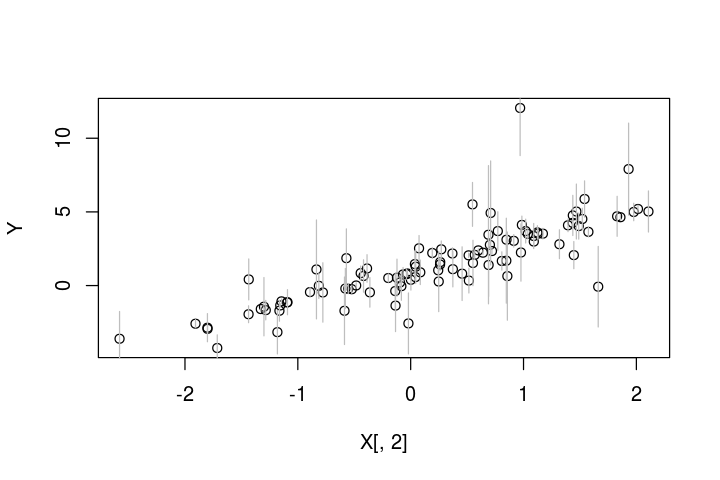

In [120]:
options(repr.plot.width=6,repr.plot.height=4)
plot(X[,2],Y)
segments(X[,2],Y+sig,X[,2],Y-sig,col='grey')

In [121]:
W <- diag(sig^-2)


In [122]:
out1 <- solve(t(X)%*%W%*%X)%*%t(X)%*%W%*%Y

In [123]:
out2 <- lm.wfit(X,Y,w=sig^-2)

In [124]:
out1
out2$coefficients

1.031440
2.010329


x1       x2 
1.031440 2.010329

In [125]:
out <- microbenchmark(solve(t(X)%*%W%*%X)%*%t(X)%*%W%*%Y,lm.wfit(X,Y,w=sig^-2))
summary(out)

expr,min,lq,mean,median,uq,max,neval
solve(t(X) %*% W %*% X) %*% t(X) %*% W %*% Y,81.599,83.334,91.82850,88.300,95.5885,155.268,100
"lm.wfit(X, Y, w = sig^-2)",47.392,50.601,54.75023,52.997,55.9720,127.104,100


Directly implementing the method from the standard mathematical expression is $O(n^2)$ while it can easily be made a $O(n)$ algorithm.